In [1]:
import pandas as pd
import numpy as np
import os

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter

import pickle as pkl
import matplotlib.pyplot as plt

%load_ext rpy2.ipython
%matplotlib inline

In [2]:
# load events, confounds, timeseries df
events = pd.read_pickle('./derivatives/both/all_subjects_events.pkl')
confounds = pd.read_pickle('./derivatives/both/all_subjects_confounds.pkl')
df = pd.read_pickle('./derivatives/both/all_subjects_stn_timeseries.pkl')

## only the accolla masks
df = df[['signal_l_limbic', 'signal_l_associative', 'signal_l_motor', 'signal_r_limbic', 'signal_r_associative', 'signal_r_motor']]

events['onset'] -= 1.5  # STC

# Fit GLM with canonical HRF

### Following GdH's PhD thesis, we fit 4 different GLMs:
1. GLM1: (a) neutral cue, (b) payoff cue, (c) easy stimulus, and (d) hard stimulus. Its first main contrast of interest was ‘payoff cue > neutral cue’, the other main contrast was ‘hard stimulus > easy stimulus’
2. GLM2: (a) neutral cue, (b) payoff cue (left), (c) payoff cue (right), (d) easy stimulus, and (e) hard stimulus. The contrast of interest was “payoff cue (left) > payoff cue (right)”.
3. GLM3: (a) neutral cue, (b) payoff cue, (d) easy stimulus (correct), (e) easy stimulus (error), (f) hard stimulus (correct), and (g) hard stimulus (error). The main contrast: ‘hard stimulus (correct) > easy stimulus (correct)’
4. GLM4: (a) neutral cue, (b) potential payoff cue, (c) easy trials, (d) hard trials, (e) left responses, and (f) right responses. Contrast: Lateralization.

# GLM 1

In [3]:
events_1 = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral'])]
events_1.loc[events_1['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'

glm1 = GroupResponseFitter(df.copy(),
                            events_1, 
                            confounds=confounds,
                            input_sample_rate=1/3, 
                            oversample_design_matrix=20, 
                            concatenate_runs=True)
for event_type in events_1.event_type.unique():
    glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

glm1.fit()

# get timecourses
tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
# fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
# fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/si

### Statistics

,mask,t,p,p.fdr,contrast
0,signal_l_limbic,0.887259,0.381560,0.572339,glm1_cue
1,signal_l_associative,0.468935,0.642295,0.642295,glm1_cue
2,signal_l_motor,2.458237,0.019560,0.117357,glm1_cue
3,signal_r_limbic,0.574469,0.569667,0.642295,glm1_cue
4,signal_r_associative,1.861546,0.071874,0.215623,glm1_cue
5,signal_r_motor,1.161992,0.253832,0.507665,glm1_cue


,mask,t,p,p.fdr,contrast
0,signal_l_limbic,0.281147,0.780408,0.907348,glm1_difficulty
1,signal_l_associative,-0.436073,0.665712,0.907348,glm1_difficulty
2,signal_l_motor,-0.614974,0.542921,0.907348,glm1_difficulty
3,signal_r_limbic,-0.117310,0.907348,0.907348,glm1_difficulty
4,signal_r_associative,-0.420919,0.676628,0.907348,glm1_difficulty
5,signal_r_motor,-0.537274,0.594795,0.907348,glm1_difficulty


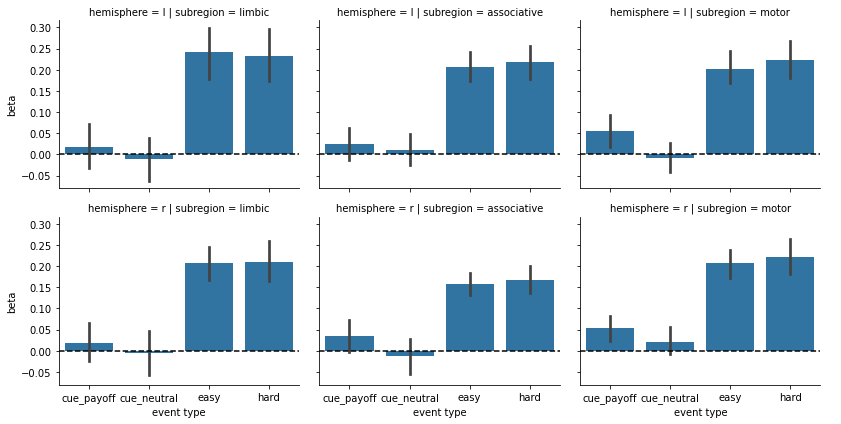

In [4]:
## to long format for plotting
GLM1_betas_long = glm1.concat_response_fitters.apply(lambda x: x.betas.loc[(['cue_payoff', 'cue_neutral', 'easy', 'hard'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True).unstack()).unstack().reset_index()
GLM1_betas_long.columns = ['roi', 'event type', 'subject', 'beta']
GLM1_betas_long['hemisphere'] = GLM1_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM1_betas_long['subregion'] = GLM1_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot beta-values
fac = sns.FacetGrid(GLM1_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['cue_payoff', 'cue_neutral', 'easy', 'hard'], ci=67)#, 'easy', 'hard'])
fac.map(plt.axhline, y=0, c='k', ls='--').set(ylabel='beta')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, cue betas
results_cue = []
for roi in GLM1_betas_long.roi.unique():
    deg_free = GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'cue_payoff'), 'beta'],
                                       GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'cue_neutral'), 'beta'])
    results_cue.append({'mask': roi, 't': tval, 'p': pval})
results_cue = pd.DataFrame(results_cue)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results_cue['p'], method='fdr_bh')
results_cue['p.fdr'] = p_fdr
results_cue['contrast'] = 'glm1_cue'
display(results_cue)

## statistics per ROI, stimulus betas
results_difficulty = []
for roi in GLM1_betas_long.roi.unique():
    tval, pval = scipy.stats.ttest_rel(GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'easy'), 'beta'],
                                       GLM1_betas_long.loc[(GLM1_betas_long['roi']==roi) & (GLM1_betas_long['event type'] == 'hard'), 'beta'])
    results_difficulty.append({'mask': roi, 't': tval, 'p': pval})
results_difficulty = pd.DataFrame(results_difficulty)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results_difficulty['p'], method='fdr_bh')
results_difficulty['p.fdr'] = p_fdr
results_difficulty['contrast'] = 'glm1_difficulty'
display(results_difficulty)

In [5]:
# Save the betas for the model-based analyses in notebook 7
GLM1_betas_long.to_pickle('./derivatives/both/STN_GLM_betavalues_accolla.pkl')

## Get Bayes Factors, use R

In [6]:
GLM1_betas_long1 = GLM1_betas_long.loc[GLM1_betas_long['event type'].isin(['cue_payoff', 'cue_neutral'])]
GLM1_betas_long1 = GLM1_betas_long1.rename(columns={'event type': 'event_type'})
GLM1_betas_long1.head()

,roi,event_type,subject,beta,hemisphere,subregion
0,signal_l_limbic,cue_payoff,1,0.199720,l,limbic
1,signal_l_limbic,cue_payoff,2,-0.626201,l,limbic
2,signal_l_limbic,cue_payoff,3,-0.459007,l,limbic
3,signal_l_limbic,cue_payoff,4,0.484232,l,limbic
4,signal_l_limbic,cue_payoff,5,0.170053,l,limbic


In [7]:
%%R -i GLM1_betas_long1 -i results_cue -o results_cue
library(BayesFactor)

b1 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'associative','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'associative','beta'], paired=TRUE)

b2 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'limbic','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'limbic','beta'], paired=TRUE)

b3 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'motor','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'l' & GLM1_betas_long1$subregion == 'motor','beta'], paired=TRUE)

b4 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'associative','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'associative','beta'], paired=TRUE)
b5 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'limbic','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'limbic','beta'], paired=TRUE)
b6 = ttestBF(GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_payoff' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'motor','beta'],
        GLM1_betas_long1[GLM1_betas_long1$event_type == 'cue_neutral' & GLM1_betas_long1$hemisphere == 'r' & GLM1_betas_long1$subregion == 'motor','beta'], paired=TRUE)

results_cue$bf10 <- NA
results_cue[results_cue$mask == 'signal_l_associative', 'bf10'] <- extractBF(b1)$bf
results_cue[results_cue$mask == 'signal_l_limbic', 'bf10'] <- extractBF(b2)$bf
results_cue[results_cue$mask == 'signal_l_motor', 'bf10'] <- extractBF(b3)$bf
results_cue[results_cue$mask == 'signal_r_associative', 'bf10'] <- extractBF(b4)$bf
results_cue[results_cue$mask == 'signal_r_limbic', 'bf10'] <- extractBF(b5)$bf
results_cue[results_cue$mask == 'signal_r_motor', 'bf10'] <- extractBF(b6)$bf

print(paste0('BF10 for L associative: ', extractBF(b1)$bf))  # substanial evidence against
print(paste0('BF10 for L limbic: ', extractBF(b2)$bf))       # anecdotal evidence against
print(paste0('BF10 for L motor: ', extractBF(b3)$bf))        # anecdotal evidence for
print(paste0('BF10 for R associative: ', extractBF(b4)$bf))  # substanial/anecdotal evidence against
print(paste0('BF10 for R limbic: ', extractBF(b5)$bf))       # substantial evidence against
print(paste0('BF10 for R motor: ', extractBF(b6)$bf))        # substantial evidence against



Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************



[1] "BF10 for L associative: 0.206262565610252"
[1] "BF10 for L limbic: 0.267698820319949"
[1] "BF10 for L motor: 2.48052520451634"
[1] "BF10 for R associative: 0.866421066283868"
[1] "BF10 for R limbic: 0.217043644298108"
[1] "BF10 for R motor: 0.34526017676407"


## Model building

Model beta values ~ event_type * hemipshere * subregion, and use model comparison to quantify evidence for/against specific independent variables

In [8]:
GLM1_betas_long1 = GLM1_betas_long1.loc[GLM1_betas_long['event type'].isin(['cue_payoff', 'cue_neutral'])]
GLM1_betas_long1 = GLM1_betas_long1.rename(columns={'event type': 'event_type'})
GLM1_betas_long1.head()

,roi,event_type,subject,beta,hemisphere,subregion
0,signal_l_limbic,cue_payoff,1,0.199720,l,limbic
1,signal_l_limbic,cue_payoff,2,-0.626201,l,limbic
2,signal_l_limbic,cue_payoff,3,-0.459007,l,limbic
3,signal_l_limbic,cue_payoff,4,0.484232,l,limbic
4,signal_l_limbic,cue_payoff,5,0.170053,l,limbic


In [9]:
GLM1_betas_long1 = GLM1_betas_long1.groupby(['subject', 'event_type', 'subregion']).beta.mean().reset_index()  #aggregate across hemispheres within subjects

In [10]:
%%R -i GLM1_betas_long1
library(BayesFactor, lib.loc='/usr/local/lib/R/site-library')
library('report', lib.loc='/usr/local/lib/R/site-library')
library('lme4', lib.loc='/usr/local/lib/R/site-library')
library('lmerTest', lib.loc='/usr/local/lib/R/site-library')

GLM1_betas_long1$subject <- factor(GLM1_betas_long1$subject)
GLM1_betas_long1$event_type <- factor(GLM1_betas_long1$event_type)
#GLM1_betas_long1$hemisphere <- factor(GLM1_betas_long1$hemisphere)
GLM1_betas_long1$subregion <- factor(GLM1_betas_long1$subregion)

# Bayes
bfTests <- generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long1, whichModels='all')
print(1/bfTests)
# print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long1, whichModels='all'))
# print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long1, whichModels='all'))

# Frequentist
lmod <- lmer(beta~event_type*subregion + (1|subject),GLM1_betas_long1) 
print(summary(lmod))
print(anova(lmod))

r <- report(lmod, df_method='satterthwaite')
print(r)
print(table_long(r))

print(report(anova(lmod)))
print(t(bfTests))

Attaching package: ‘lmerTest’



    lmer



    step




  |======================================================================| 100%
                denominator
numerator        event_type subregion event_type:subregion
  Intercept only    3.67545   15.9094             10.46938
                denominator
numerator        event_type + subregion event_type + event_type:subregion
  Intercept only               59.06249                          38.83344
                denominator
numerator        subregion + event_type:subregion
  Intercept only                         171.5449
                denominator
numerator        event_type + subregion + event_type:subregion
  Intercept only                                      613.5401
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: beta ~ event_type * subregion + (1 | subject)
   Data: GLM1_betas_long1

REML criterion at convergence: -142.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.82965 -0.51435  0.00052  0.49540  3.09983

In [11]:
# %%R -i GLM1_betas_long1
# library(BayesFactor, lib.loc='/usr/local/lib/R/site-library')
# library('report', lib.loc='/usr/local/lib/R/site-library')
# library('lme4', lib.loc='/usr/local/lib/R/site-library')
# library('lmerTest', lib.loc='/usr/local/lib/R/site-library')

# GLM1_betas_long1$subject <- factor(GLM1_betas_long1$subject)
# GLM1_betas_long1$event_type <- factor(GLM1_betas_long1$event_type)
# GLM1_betas_long1$hemisphere <- factor(GLM1_betas_long1$hemisphere)
# GLM1_betas_long1$subregion <- factor(GLM1_betas_long1$subregion)

# # Bayes
# print(generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long1, whichModels='all'))

# # Frequentist
# lmod <- lmer(beta~event_type*subregion + (1|subject),GLM1_betas_long1) 
# print(summary(lmod))
# print(anova(lmod))

# r <- report(lmod, df_method='satterthwaite')
# print(r)
# print(table_long(r))

# print(report(anova(lmod)))

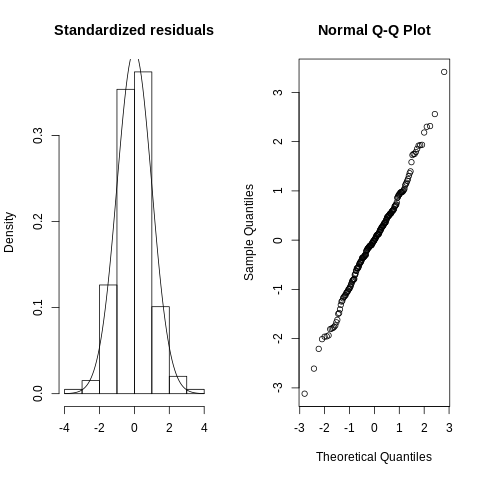

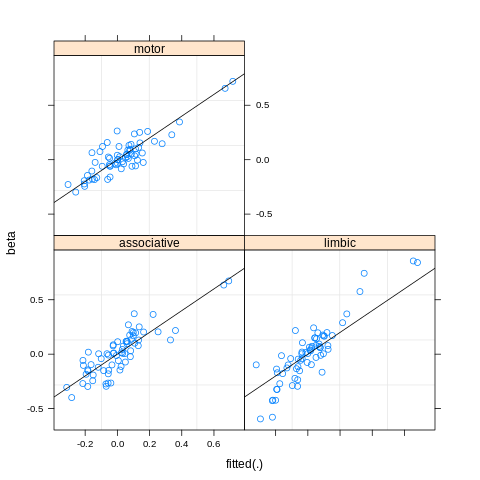

In [12]:
%%R
par(mfrow=c(1,2))
hist((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T), freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T))
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | event_type, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | subregion, abline = c(0,1))

### Repeat the t-tests and LMEMs, using the stimuli-betas as DVs

In [13]:
GLM1_betas_long2 = GLM1_betas_long.loc[GLM1_betas_long['event type'].isin(['easy', 'hard'])]
GLM1_betas_long2 = GLM1_betas_long2.rename(columns={'event type': 'event_type'})

In [14]:
%%R -i GLM1_betas_long2 -i results_difficulty -o results_difficulty
library(BayesFactor)

GLM1_betas_long2$event_type <- factor(GLM1_betas_long2$event_type)
GLM1_betas_long2$hemisphere <- factor(GLM1_betas_long2$hemisphere)
GLM1_betas_long2$subregion <- factor(GLM1_betas_long2$subregion)

b1 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'associative','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'associative','beta'], paired=TRUE)

b2 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'limbic','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'limbic','beta'], paired=TRUE)

b3 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'motor','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'l' & GLM1_betas_long2$subregion == 'motor','beta'], paired=TRUE)

b4 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'associative','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'associative','beta'], paired=TRUE)
b5 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'limbic','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'limbic','beta'], paired=TRUE)
b6 = ttestBF(GLM1_betas_long2[GLM1_betas_long2$event_type == 'hard' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'motor','beta'],
        GLM1_betas_long2[GLM1_betas_long2$event_type == 'easy' & GLM1_betas_long2$hemisphere == 'r' & GLM1_betas_long2$subregion == 'motor','beta'], paired=TRUE)

print(paste0('BF10 for L associative: ', extractBF(b1)$bf))
print(paste0('BF10 for L limbic: ', extractBF(b2)$bf))
print(paste0('BF10 for L motor: ', extractBF(b3)$bf))
print(paste0('BF10 for R associative: ', extractBF(b4)$bf))
print(paste0('BF10 for R limbic: ', extractBF(b5)$bf))
print(paste0('BF10 for R motor: ', extractBF(b6)$bf))

results_difficulty$bf10 <- NA
results_difficulty[results_difficulty$mask == 'signal_l_associative', 'bf10'] <- extractBF(b1)$bf
results_difficulty[results_difficulty$mask == 'signal_l_limbic', 'bf10'] <- extractBF(b2)$bf
results_difficulty[results_difficulty$mask == 'signal_l_motor', 'bf10'] <- extractBF(b3)$bf
results_difficulty[results_difficulty$mask == 'signal_r_associative', 'bf10'] <- extractBF(b4)$bf
results_difficulty[results_difficulty$mask == 'signal_r_limbic', 'bf10'] <- extractBF(b5)$bf
results_difficulty[results_difficulty$mask == 'signal_r_motor', 'bf10'] <- extractBF(b6)$bf

[1] "BF10 for L associative: 0.203437812257486"
[1] "BF10 for L limbic: 0.193200954143503"
[1] "BF10 for L motor: 0.221924410334012"
[1] "BF10 for R associative: 0.202215727220164"
[1] "BF10 for R limbic: 0.187413424686039"
[1] "BF10 for R motor: 0.212934633943606"


In [15]:
GLM1_betas_long2 = GLM1_betas_long2.groupby(['subject', 'event_type', 'subregion']).beta.mean().reset_index()  #aggregate across hemispheres within subjects

In [16]:
%%R -i GLM1_betas_long2 -i results_difficulty -o results_difficulty

# Models
print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM1_betas_long2, whichModels='all'))

lmod <- lmer(beta~event_type*subregion + (1|subject), GLM1_betas_long2) 
summary(lmod)
anova(lmod)

  |======================================================================| 100%
                denominator
numerator        event_type subregion event_type:subregion
  Intercept only   6.260084  13.34551              10.5263
                denominator
numerator        event_type + subregion event_type + event_type:subregion
  Intercept only               86.35998                          65.83242
                denominator
numerator        subregion + event_type:subregion
  Intercept only                         137.9013
                denominator
numerator        event_type + subregion + event_type:subregion
  Intercept only                                      831.6663
Type III Analysis of Variance Table with Satterthwaite's method
                       Sum Sq   Mean Sq NumDF DenDF F value Pr(>F)
event_type           0.003655 0.0036546     1   160  0.2111 0.6465
subregion            0.043352 0.0216761     2   160  1.2522 0.2887
event_type:subregion 0.003659 0.0018297     2   160

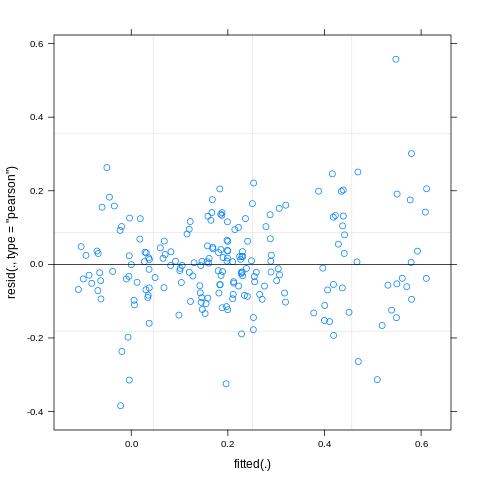

In [17]:
%%R
plot(lmod)

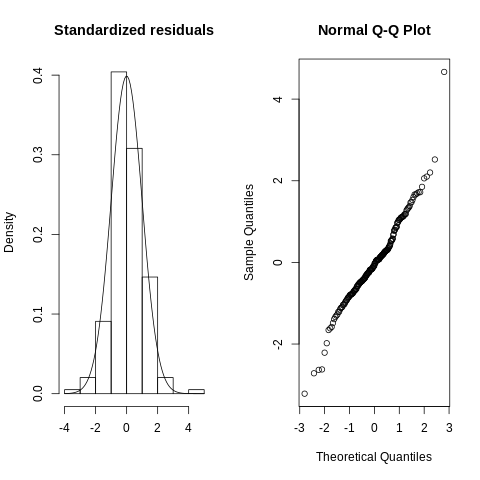

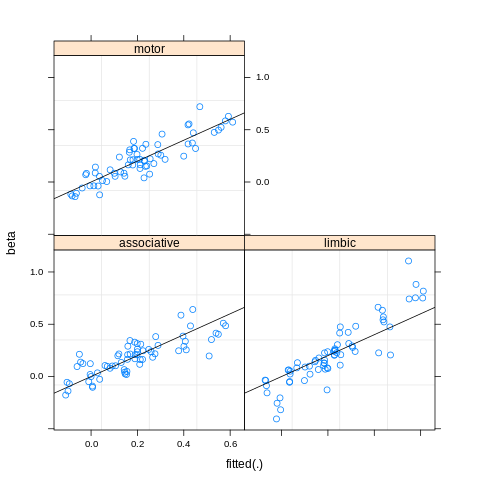

In [18]:
%%R
par(mfrow=c(1,2))
hist((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T), freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T))
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | event_type, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | subregion, abline = c(0,1))

# GLM 2

In [19]:
events_2 = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral'])].copy()

glm2 = GroupResponseFitter(df.copy(), 
                            events_2, 
                            confounds=confounds.copy(),
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_2.event_type.unique():
    glm2.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
glm2.fit()

# get timecourses
tc = glm2.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
# fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
# fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


### Statistics

,mask,t,p,p.fdr,contrast
0,signal_l_limbic,-1.736541,0.092088,0.552528,glm2_cues
1,signal_l_associative,-0.004252,0.996633,0.996633,glm2_cues
2,signal_l_motor,0.266306,0.791712,0.996633,glm2_cues
3,signal_r_limbic,0.491361,0.626525,0.996633,glm2_cues
4,signal_r_associative,0.070118,0.944536,0.996633,glm2_cues
5,signal_r_motor,-1.224480,0.229710,0.689129,glm2_cues


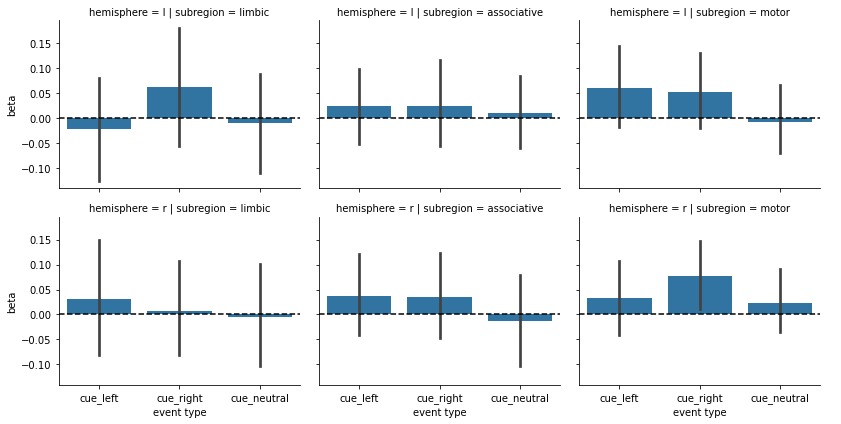

In [20]:
## long format for plotting
GLM2_betas_long = glm2.concat_response_fitters.apply(lambda x: x.betas.loc[(['cue_left', 'cue_right', 'cue_neutral', 'easy', 'hard'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True).unstack()).unstack().reset_index()
GLM2_betas_long.columns = ['roi', 'event type', 'subject', 'beta']
GLM2_betas_long['hemisphere'] = GLM2_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM2_betas_long['subregion'] = GLM2_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM2_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['cue_left', 'cue_right', 'cue_neutral'])#, 'easy', 'hard'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM2_betas_long.roi.unique():
    deg_free = GLM2_betas_long.loc[(GLM2_betas_long['roi']==roi) & (GLM2_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM2_betas_long.loc[(GLM2_betas_long['roi']==roi) & (GLM2_betas_long['event type'] == 'cue_left'), 'beta'],
                                       GLM2_betas_long.loc[(GLM2_betas_long['roi']==roi) & (GLM2_betas_long['event type'] == 'cue_right'), 'beta'])
    #print("Subregion {}, contrast cue_left != cue_right, t({}) = {:.4f}, p = {:.4f}".format(roi, deg_free, tval, pval))
    results.append({'mask': roi, 't': tval, 'p': pval})

results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'glm2_cues'
display(results)
results_glm2 = results.copy()

In [21]:
GLM2_betas_longR = GLM2_betas_long.loc[GLM2_betas_long['event type'].isin(['cue_left', 'cue_right'])]
GLM2_betas_longR = GLM2_betas_longR.rename(columns={'event type': 'event_type'})

GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_left') & (GLM2_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'ipsilateral'
GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_right') & (GLM2_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'contralateral'
GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_left') & (GLM2_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'contralateral'
GLM2_betas_longR.loc[(GLM2_betas_longR['event_type'] == 'cue_right') & (GLM2_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'ipsilateral'
GLM2_betas_longR

,roi,event_type,subject,beta,hemisphere,subregion,event_type2
0,signal_l_limbic,cue_left,1,-0.364481,l,limbic,ipsilateral
1,signal_l_limbic,cue_left,2,-0.566754,l,limbic,ipsilateral
2,signal_l_limbic,cue_left,3,-0.398579,l,limbic,ipsilateral
3,signal_l_limbic,cue_left,4,0.503840,l,limbic,ipsilateral
4,signal_l_limbic,cue_left,5,0.238563,l,limbic,ipsilateral
...,...,...,...,...,...,...,...
886,signal_r_motor,cue_right,30,0.163959,r,motor,ipsilateral
887,signal_r_motor,cue_right,31,0.041334,r,motor,ipsilateral
888,signal_r_motor,cue_right,32,-0.047952,r,motor,ipsilateral
889,signal_r_motor,cue_right,33,0.104155,r,motor,ipsilateral


In [22]:
GLM2_betas_longR2 = GLM2_betas_longR.groupby(['subject', 'event_type2', 'subregion']).beta.mean().reset_index()  # Aggregate within subject (ie mean hemispheres)

In [23]:
%%R -i GLM2_betas_longR -i results_glm2 -i GLM2_betas_longR2 -o results_glm2
library(BayesFactor)
GLM2_betas_longR$laterality <- factor(GLM2_betas_longR$event_type2)
GLM2_betas_longR$hemisphere <- factor(GLM2_betas_longR$hemisphere)
GLM2_betas_longR$subregion <- factor(GLM2_betas_longR$subregion)

b1 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'associative','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'associative','beta'], paired=TRUE)

b2 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'limbic','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'limbic','beta'], paired=TRUE)

b3 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'motor','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'l' & GLM2_betas_longR$subregion == 'motor','beta'], paired=TRUE)

b4 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'associative','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'associative','beta'], paired=TRUE)
b5 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'limbic','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'limbic','beta'], paired=TRUE)
b6 = ttestBF(GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_left' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'motor','beta'],
        GLM2_betas_longR[GLM2_betas_longR$event_type == 'cue_right' & GLM2_betas_longR$hemisphere == 'r' & GLM2_betas_longR$subregion == 'motor','beta'], paired=TRUE)

print(paste0('BF10 for L associative: ', extractBF(b1)$bf))
print(paste0('BF10 for L limbic: ', extractBF(b2)$bf))
print(paste0('BF10 for L motor: ', extractBF(b3)$bf))
print(paste0('BF10 for R associative: ', extractBF(b4)$bf))
print(paste0('BF10 for R limbic: ', extractBF(b5)$bf))
print(paste0('BF10 for R motor: ', extractBF(b6)$bf))

results_glm2$bf <- NA
results_glm2[results_glm2$mask == 'signal_l_associative', 'bf10'] <- extractBF(b1)$bf
results_glm2[results_glm2$mask == 'signal_l_limbic', 'bf10'] <- extractBF(b2)$bf
results_glm2[results_glm2$mask == 'signal_l_motor', 'bf10'] <- extractBF(b3)$bf
results_glm2[results_glm2$mask == 'signal_r_associative', 'bf10'] <- extractBF(b4)$bf
results_glm2[results_glm2$mask == 'signal_r_limbic', 'bf10'] <- extractBF(b5)$bf
results_glm2[results_glm2$mask == 'signal_r_motor', 'bf10'] <- extractBF(b6)$bf

# Bayes
GLM2_betas_longR2$laterality <- factor(GLM2_betas_longR2$event_type2)
print(1/generalTestBF(beta ~ 1 + laterality*subregion, whichRandom="subject", data = GLM2_betas_longR2, whichModels='all'))

# Frequentist
lmod <- lmer(beta~laterality*subregion + (1|subject), GLM2_betas_longR2) 
summary(lmod)
anova(lmod)

[1] "BF10 for L associative: 0.186215851122409"
[1] "BF10 for L limbic: 0.715696172239631"
[1] "BF10 for L motor: 0.192471660386722"
[1] "BF10 for R associative: 0.186641869883618"
[1] "BF10 for R limbic: 0.208330805450391"
[1] "BF10 for R motor: 0.369073444891868"
  |======================================================================| 100%
                denominator
numerator        laterality subregion laterality:subregion
  Intercept only   6.208436  13.36151             7.245473
                denominator
numerator        laterality + subregion laterality + laterality:subregion
  Intercept only               86.07433                          46.67513
                denominator
numerator        subregion + laterality:subregion
  Intercept only                         97.41469
                denominator
numerator        laterality + subregion + laterality:subregion
  Intercept only                                      598.8167
Type III Analysis of Variance Table with Satterthw

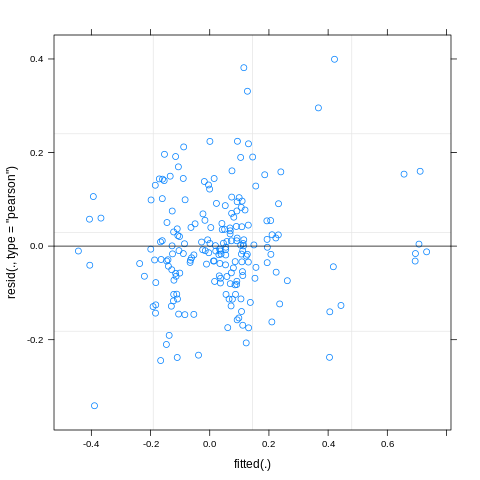

In [24]:
%%R 
plot(lmod)

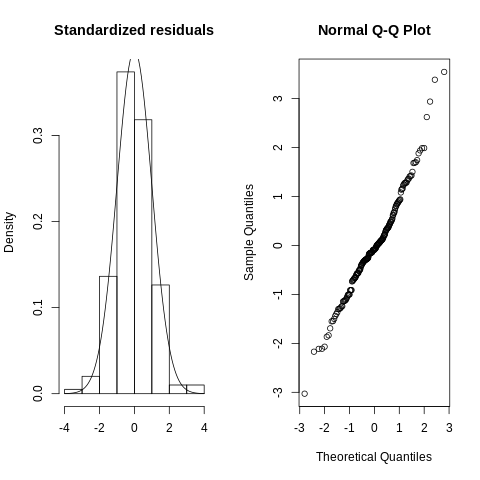

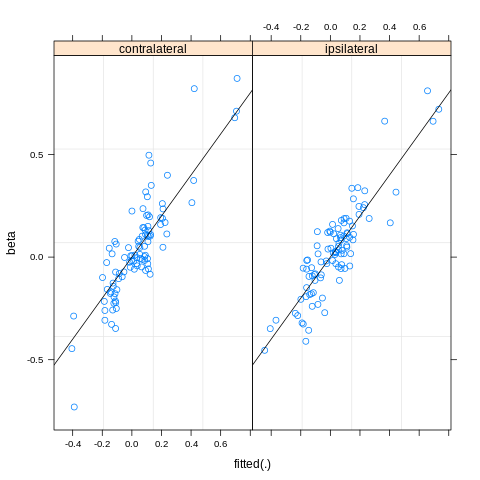

In [25]:
%%R 
par(mfrow=c(1,2))
hist((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T), freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm((resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T))
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | laterality, abline = c(0,1))

## GLM3

In [26]:
def combine_difficulty(x):
    x['next_event'] = x['event_type'].shift(-1)
    x['event_type'] = x['event_type'] + '_' + x['next_event']
    x = x.loc[x['event_type'].isin(['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])]
    return x[['onset', 'event_type', 'duration']]

tmp = events.copy().reset_index()
tmp = tmp.loc[tmp['event_type'].isin(['easy', 'hard', 'error', 'correct'])]
stim_diff = tmp.groupby(['subject', 'run']).apply(lambda x: combine_difficulty(x)).reset_index(level=2, drop=True)

tmp = events.copy()
tmp = tmp.loc[tmp['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral'])]
events_3 = pd.concat([tmp, stim_diff]).sort_values(['subject', 'run', 'onset'])

In [27]:
# def combine_difficulty_accuracy(x):
#     return '_'.join(x['event_type'].values)

# events_1c = events.copy().reset_index()
# events_1c = events_1c.loc[events_1c['event_type'].isin(['cue_payoff', 'easy', 'hard', 'cue_neutral', 'error', 'correct'])]
# events_1c = events_1c.groupby(['subject', 'run', 'onset']).apply(lambda x: combine_difficulty_accuracy(x)).reset_index().set_index(['subject', 'run'])
# events_1c = events_1c.rename(columns={0: 'event_type'})

# events_1c.loc[events_1c['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'
# events_1c = events_1c.loc[~events_1c['event_type'].isin(['response_left', 'response_right'])]
# events_1c.head()

In [28]:
glm3 = GroupResponseFitter(df.copy(), 
                            events_3, 
                            confounds=confounds.copy(),
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_3.event_type.unique():
    glm3.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])
glm3.fit()

# get timecourses
tc = glm3.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# plot
# fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
# fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/group_analysis.py:161: UserWarning: Event hard_correct is not available for run (1, 1). Event is ignored for this run
  'run' % (e, col))
/home/stevenm/.conda/envs/python3/lib/python

,mask,t,p,p.fdr,contrast
0,signal_l_associative,0.258757,0.797480,0.956976,glm3
1,signal_l_limbic,-1.059656,0.297234,0.891703,glm3
2,signal_l_motor,0.029551,0.976609,0.976609,glm3
3,signal_r_associative,1.200727,0.238670,0.891703,glm3
4,signal_r_limbic,0.405948,0.687482,0.956976,glm3
5,signal_r_motor,0.416882,0.679548,0.956976,glm3


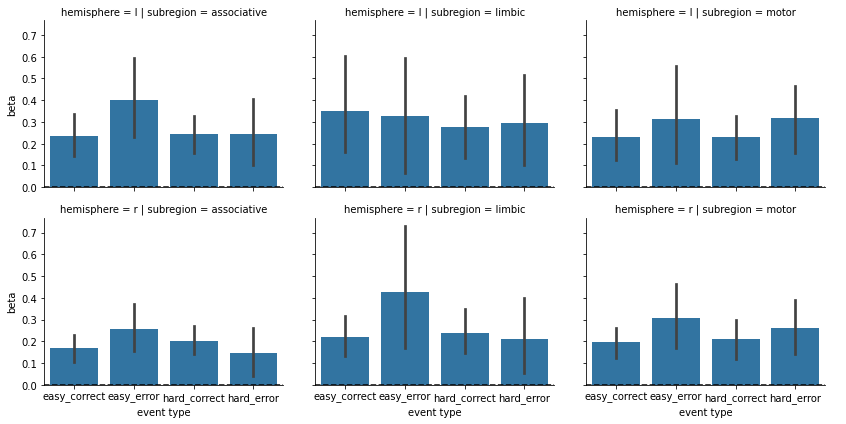

In [29]:
## long format for plotting
GLM3_betas_long = glm3.concat_response_fitters.apply(lambda x: x.betas.loc[(['cue_payoff', 'cue_neutral', 'easy_correct', 'hard_correct', 'easy_error', 'hard_error'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True).unstack()).unstack().reset_index()
GLM3_betas_long.columns = ['roi', 'event type', 'subject', 'beta']
GLM3_betas_long['hemisphere'] = GLM3_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM3_betas_long['subregion'] = GLM3_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM3_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM3_betas_long.roi.unique():
    deg_free = GLM3_betas_long.loc[(GLM3_betas_long['roi']==roi) & (GLM3_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM3_betas_long.loc[(GLM3_betas_long['roi']==roi) & (GLM3_betas_long['event type'] == 'hard_correct'), 'beta'],
                                       GLM3_betas_long.loc[(GLM3_betas_long['roi']==roi) & (GLM3_betas_long['event type'] == 'easy_correct'), 'beta'])
    results.append({'mask': roi, 't': tval, 'p': pval})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'glm3'
results_glm3 = results.copy()
display(results)

In [30]:
GLM3_betas_longR = GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['hard_correct', 'easy_correct'])]
GLM3_betas_longR = GLM3_betas_longR.rename(columns={'event type': 'event_type'})
GLM3_betas_longR

,roi,event_type,subject,beta,hemisphere,subregion
33,signal_l_associative,easy_correct,1,1.470170,l,associative
34,signal_l_associative,easy_correct,2,0.588817,l,associative
35,signal_l_associative,easy_correct,3,0.293606,l,associative
36,signal_l_associative,easy_correct,4,0.063344,l,associative
37,signal_l_associative,easy_correct,5,0.181346,l,associative
...,...,...,...,...,...,...
952,signal_r_motor,hard_correct,30,0.143106,r,motor
953,signal_r_motor,hard_correct,31,-0.218008,r,motor
954,signal_r_motor,hard_correct,32,0.393409,r,motor
955,signal_r_motor,hard_correct,33,0.106556,r,motor


In [31]:
GLM3_betas_longR2 = GLM3_betas_longR.groupby(['subject', 'event_type', 'subregion']).beta.mean().reset_index()

In [32]:
%%R -i GLM3_betas_longR -i GLM3_betas_longR2 -i results_glm3 -o results_glm3
library(BayesFactor)
GLM3_betas_longR$event_type <- factor(GLM3_betas_longR$event_type)
GLM3_betas_longR$hemisphere <- factor(GLM3_betas_longR$hemisphere)
GLM3_betas_longR$subregion <- factor(GLM3_betas_longR$subregion)

b1 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'associative','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'associative','beta'], paired=TRUE)

b2 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'limbic','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'limbic','beta'], paired=TRUE)

b3 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'motor','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'l' & GLM3_betas_longR$subregion == 'motor','beta'], paired=TRUE)

b4 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'associative','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'associative','beta'], paired=TRUE)
b5 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'limbic','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'limbic','beta'], paired=TRUE)
b6 = ttestBF(GLM3_betas_longR[GLM3_betas_longR$event_type == 'hard_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'motor','beta'],
        GLM3_betas_longR[GLM3_betas_longR$event_type == 'easy_correct' & GLM3_betas_longR$hemisphere == 'r' & GLM3_betas_longR$subregion == 'motor','beta'], paired=TRUE)

results_glm3[results_glm3$mask == 'signal_l_associative', 'bf10'] <- extractBF(b1)$bf
results_glm3[results_glm3$mask == 'signal_l_limbic', 'bf10'] <- extractBF(b2)$bf
results_glm3[results_glm3$mask == 'signal_l_motor', 'bf10'] <- extractBF(b3)$bf
results_glm3[results_glm3$mask == 'signal_r_associative', 'bf10'] <- extractBF(b4)$bf
results_glm3[results_glm3$mask == 'signal_r_limbic', 'bf10'] <- extractBF(b5)$bf
results_glm3[results_glm3$mask == 'signal_r_motor', 'bf10'] <- extractBF(b6)$bf

print(paste0('BF10 for L associative: ', extractBF(b1)$bf))
print(paste0('BF10 for L limbic: ', extractBF(b2)$bf))
print(paste0('BF10 for L motor: ', extractBF(b3)$bf))
print(paste0('BF10 for R associative: ', extractBF(b4)$bf))
print(paste0('BF10 for R limbic: ', extractBF(b5)$bf))
print(paste0('BF10 for R motor: ', extractBF(b6)$bf))

# Bayes
print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM3_betas_longR2, whichModels='all'))

# Frequentist
lmod <- lmer(beta~event_type*subregion + (1|subject), GLM3_betas_longR2) 
summary(lmod)
anova(lmod)

[1] "BF10 for L associative: 0.192116804430853"
[1] "BF10 for L limbic: 0.311704147654301"
[1] "BF10 for L motor: 0.186290160246422"
[1] "BF10 for R associative: 0.359698149526186"
[1] "BF10 for R limbic: 0.201057216291772"
[1] "BF10 for R motor: 0.201898572541003"
  |======================================================================| 100%
                denominator
numerator        event_type subregion event_type:subregion
  Intercept only   6.469708  8.578899             9.579768
                denominator
numerator        event_type + subregion event_type + event_type:subregion
  Intercept only               53.78869                          59.96489
                denominator
numerator        subregion + event_type:subregion
  Intercept only                         82.93906
                denominator
numerator        event_type + subregion + event_type:subregion
  Intercept only                                      542.4505
Type III Analysis of Variance Table with Satterthw

## What about accuracy x difficulty?

In [33]:
GLM3_betas_longR2 = GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['hard_correct', 'easy_correct', 'hard_error', 'easy_error'])]
GLM3_betas_longR2 = GLM3_betas_longR2.rename(columns={'event type': 'event_type'})
GLM3_betas_longR2['difficulty'] = GLM3_betas_longR2['event_type'].apply(lambda x: x.split('_')[0])
GLM3_betas_longR2['accuracy'] = GLM3_betas_longR2['event_type'].apply(lambda x: x.split('_')[1])

Type III Analysis of Variance Table with Satterthwaite's method
                     Sum Sq Mean Sq NumDF  DenDF F value  Pr(>F)  
accuracy            0.66475 0.66475     1 750.44  4.8403 0.02811 *
difficulty          0.41340 0.41340     1 750.44  3.0101 0.08316 .
accuracy:difficulty 0.41965 0.41965     1 750.44  3.0556 0.08087 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


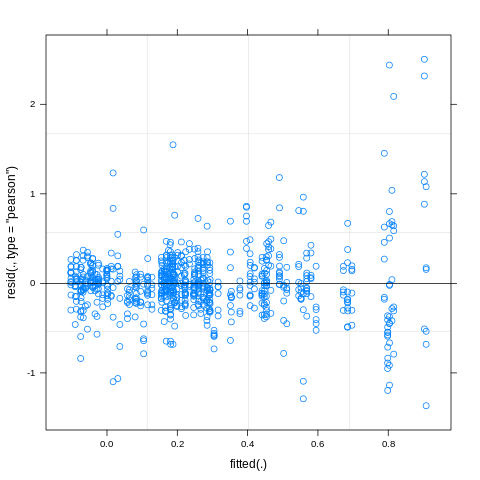

In [34]:
%%R -i GLM3_betas_longR2
library(BayesFactor)
library(lme4)
library(lmerTest)

# GLM3_betas_longR2$difficulty <- factor(GLM3_betas_longR2$difficulty)
# GLM3_betas_longR2$accuracy <- factor(GLM3_betas_longR2$accuracy)
#GLM3_betas_longR_ <- GLM3_betas_longR2[-c(79,  94, 209, 216, 218, 340, 356, 582, 618, 621),]
GLM3_betas_longR2$difficulty <- factor(GLM3_betas_longR2$difficulty)
GLM3_betas_longR2$accuracy <- factor(GLM3_betas_longR2$accuracy)

lmod <- lmer(beta~accuracy*difficulty + (1|subject), GLM3_betas_longR2)
summary(lmod)
print(anova(lmod))
plot(lmod)

In [35]:
%%R
par(mfrow=c(1,2))
standardized_res = (resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T)
hist(standardized_res, freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm(standardized_res)
abline(a=0,b=1)
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | accuracy, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | difficulty, abline = c(0,1))

  replacement has 792 rows, data has 786




Error in `[<-.data.frame`(`*tmp*`, , ".y", value = c(1.47016974285624,  : 
  replacement has 792 rows, data has 786


#### The interaction approximates significance, but the assumption checks look terrible (highly non-Gaussian, right-skewed residuals) Quite some subjects have very few errors in the easy condition, which leads to a very unstable beta-estimate. Let's see what the results look like when we only consider subs with >= 15 of these datapoints

In [36]:
counts = events_3.groupby(level=0).event_type.value_counts()#.reset_index()
counts.name = 'count'
counts = counts.reset_index()
drop_subs = counts.loc[(counts['event_type'] == 'easy_error') & (counts['count'] < 15), 'subject'].values

In [37]:
GLM3_betas_long_excl = GLM3_betas_long.copy()
GLM3_betas_long_excl = GLM3_betas_long_excl.loc[~(GLM3_betas_long_excl.subject.isin(drop_subs))]

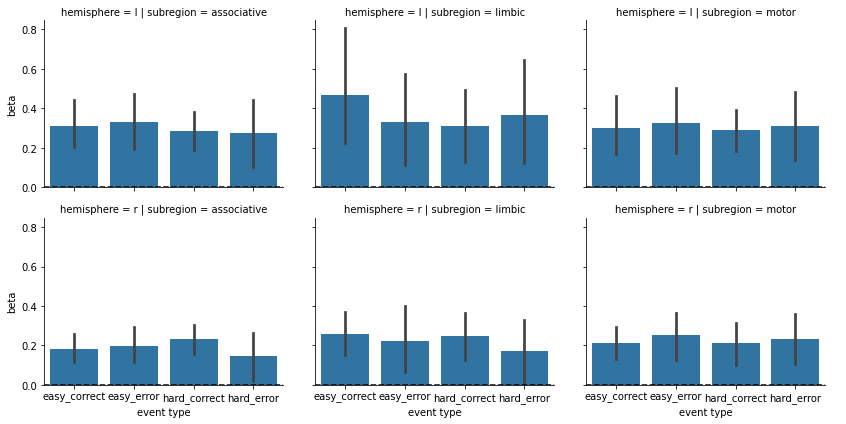

In [38]:
## Plot
fac = sns.FacetGrid(GLM3_betas_long_excl, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

In [39]:
GLM3_betas_long_excl = GLM3_betas_long_excl.rename(columns={'event type': 'event_type'})
GLM3_betas_long_excl['difficulty'] = GLM3_betas_long_excl['event_type'].apply(lambda x: x.split('_')[0])
GLM3_betas_long_excl['accuracy'] = GLM3_betas_long_excl['event_type'].apply(lambda x: x.split('_')[1])


Interpret type III hypotheses with care.



Type III Analysis of Variance Table with Satterthwaite's method
                    Sum Sq Mean Sq NumDF  DenDF F value Pr(>F)    
accuracy            7.6718  3.8359     2 657.27 38.6371 <2e-16 ***
difficulty          0.0886  0.0886     1 657.48  0.8921 0.3453    
accuracy:difficulty 0.0001  0.0001     1 657.48  0.0013 0.9713    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


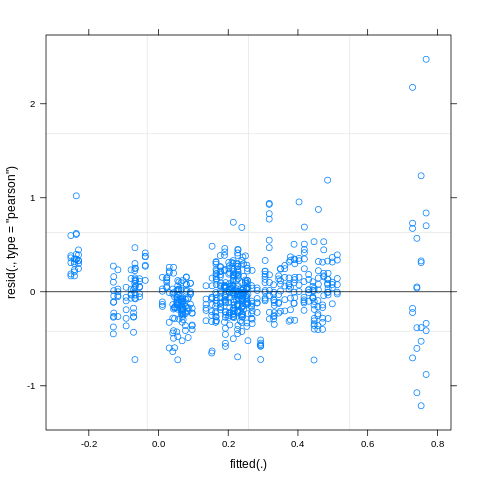

In [40]:
%%R -i GLM3_betas_long_excl
library(BayesFactor)
library(lme4)
library(lmerTest)

# GLM3_betas_long_excl$difficulty <- factor(GLM3_betas_long_excl$difficulty)
# GLM3_betas_long_excl$accuracy <- factor(GLM3_betas_long_excl$accuracy)
#GLM3_betas_longR_ <- GLM3_betas_long_excl[-c(79,  94, 209, 216, 218, 340, 356, 582, 618, 621),]
GLM3_betas_long_excl$difficulty <- factor(GLM3_betas_long_excl$difficulty)
GLM3_betas_long_excl$accuracy <- factor(GLM3_betas_long_excl$accuracy)

lmod <- lmer(beta~accuracy*difficulty + (1|subject), GLM3_betas_long_excl)
summary(lmod)
print(anova(lmod))
plot(lmod)

In [41]:
%%R
par(mfrow=c(1,2))
standardized_res = (resid(lmod) - mean(resid(lmod), na.rm=T)) / sd(resid(lmod), na.rm=T)
hist(standardized_res, freq=F, main='Standardized residuals', xlab=''); curve(dnorm, add = TRUE)
qqnorm(standardized_res)
abline(a=0,b=1)
plot(lmod)  # these plots don't appear in the jupyter notebook
plot(lmod, beta ~ fitted(.) | accuracy, abline = c(0,1))
plot(lmod, beta ~ fitted(.) | difficulty, abline = c(0,1))

  replacement has 690 rows, data has 684




Error in `[<-.data.frame`(`*tmp*`, , ".y", value = c(0.164194271892939,  : 
  replacement has 690 rows, data has 684


#### Residuals look (a bit) better now, and the interaction effect is gone

# GLM4

In [42]:
events_4 = events.loc[events['event_type'].isin(['easy', 'hard', 'cue_left', 'cue_right', 'cue_neutral', 'response_left', 'response_right'])]
events_4.loc[events_4['event_type'].isin(['cue_left', 'cue_right']), 'event_type'] = 'cue_payoff'

glm4 = GroupResponseFitter(df.copy(), 
                            events_4, 
                            confounds=confounds,
                            input_sample_rate=1/3, oversample_design_matrix=20, concatenate_runs=True)
for event_type in events_4.event_type.unique():
    glm4.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0, 18])

glm4.fit()

# get timecourses
tc = glm4.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')
tc['hemisphere'] = tc['roi'].str.split('_').apply(lambda x: x[1])
tc['subregion'] = tc['roi'].str.split('_').apply(lambda x: x[2])

# # plot
# fac = sns.FacetGrid(tc, row='hemisphere', col='subregion')
# fac.map_dataframe(sns.lineplot, x='time', hue='event type', y='signal', color=sns.color_palette())
# fac.map(plt.axhline, y=0, c='k', ls='--')
# fac.map(plt.axvline, x=0, c='k', ls='--')
# fac.add_legend()

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.X = pd.concat((self.X, regressor.X), 1)
/home/stevenm/.conda/envs/python3/lib/python3.7/si

,mask,t,p,p.fdr,contrast
0,signal_l_limbic,0.833621,0.410674,0.89888,glm4
1,signal_l_associative,-1.465558,0.152526,0.89888,glm4
2,signal_l_motor,-0.765744,0.449440,0.89888,glm4
3,signal_r_limbic,-0.503210,0.618263,0.90107,glm4
4,signal_r_associative,0.125300,0.901070,0.90107,glm4
5,signal_r_motor,0.237843,0.813519,0.90107,glm4


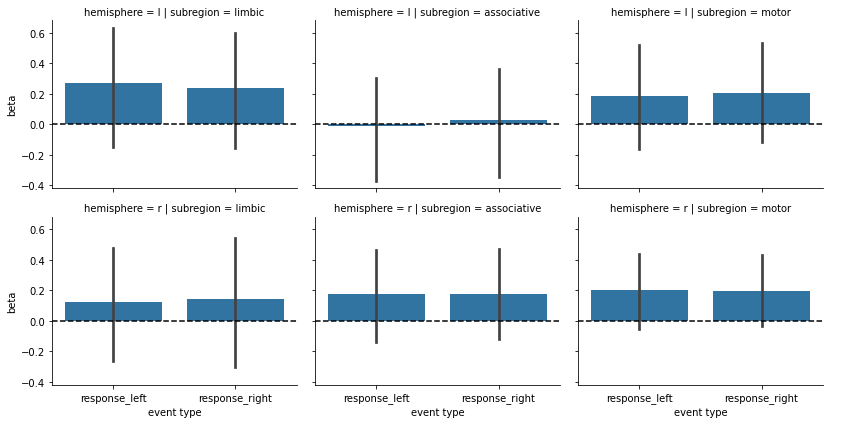

In [43]:
## long format for plotting
GLM4_betas_long = glm4.concat_response_fitters.apply(lambda x: x.betas.loc[(['response_left', 'response_right'], 'intercept', 'HRF')].reset_index(level=[1,2], drop=True).unstack()).unstack().reset_index()
GLM4_betas_long.columns = ['roi', 'event type', 'subject', 'beta']
GLM4_betas_long['hemisphere'] = GLM4_betas_long['roi'].str.split('_').apply(lambda x: x[1])
GLM4_betas_long['subregion'] = GLM4_betas_long['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(GLM4_betas_long, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  x='event type',
                  y='beta', order=['response_left', 'response_right'])
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(12,6)

## statistics per ROI, single contrast
results = []
for roi in GLM4_betas_long.roi.unique():
    deg_free = GLM4_betas_long.loc[(GLM4_betas_long['roi']==roi) & (GLM4_betas_long['event type'] == 'cue_payoff'), 'beta'].shape[0] - 1
    tval, pval = scipy.stats.ttest_rel(GLM4_betas_long.loc[(GLM4_betas_long['roi']==roi) & (GLM4_betas_long['event type'] == 'response_left'), 'beta'],
                                       GLM4_betas_long.loc[(GLM4_betas_long['roi']==roi) & (GLM4_betas_long['event type'] == 'response_right'), 'beta'])
    results.append({'mask': roi, 't': tval, 'p': pval})
    
results = pd.DataFrame(results)
_, p_fdr, _, _ = statsmodels.stats.multitest.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results['contrast'] = 'glm4'
results_glm4 = results.copy()
display(results)

In [44]:
GLM4_betas_longR = GLM4_betas_long.loc[GLM4_betas_long['event type'].isin(['response_left', 'response_right'])]
GLM4_betas_longR = GLM4_betas_longR.rename(columns={'event type': 'event_type'})

GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_left') & (GLM4_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'ipsilateral'
GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_right') & (GLM4_betas_longR.roi.str.match('.*_l_*')), 'event_type2'] = 'contralateral'
GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_left') & (GLM4_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'contralateral'
GLM4_betas_longR.loc[(GLM4_betas_longR['event_type'] == 'response_right') & (GLM4_betas_longR.roi.str.match('.*_r_*')), 'event_type2'] = 'ipsilateral'
GLM4_betas_longR

,roi,event_type,subject,beta,hemisphere,subregion,event_type2
0,signal_l_limbic,response_left,1,-1.371122,l,limbic,ipsilateral
1,signal_l_limbic,response_left,2,1.132841,l,limbic,ipsilateral
2,signal_l_limbic,response_left,3,1.235663,l,limbic,ipsilateral
3,signal_l_limbic,response_left,4,-0.461126,l,limbic,ipsilateral
4,signal_l_limbic,response_left,5,1.803573,l,limbic,ipsilateral
...,...,...,...,...,...,...,...
391,signal_r_motor,response_right,30,-0.496882,r,motor,ipsilateral
392,signal_r_motor,response_right,31,-0.431527,r,motor,ipsilateral
393,signal_r_motor,response_right,32,-0.936463,r,motor,ipsilateral
394,signal_r_motor,response_right,33,-0.302494,r,motor,ipsilateral


In [45]:
GLM4_betas_longR2 = GLM4_betas_longR.groupby(['subject', 'event_type', 'event_type2', 'subregion']).beta.mean().reset_index()

In [46]:
%%R -i GLM4_betas_longR -i GLM4_betas_longR2 -i results_glm4 -o results_glm4
library(BayesFactor)
GLM4_betas_longR$event_type <- factor(GLM4_betas_longR$event_type)
GLM4_betas_longR$hemisphere <- factor(GLM4_betas_longR$hemisphere)
GLM4_betas_longR$subregion <- factor(GLM4_betas_longR$subregion)

b1 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'associative','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'associative','beta'], paired=TRUE)

b2 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'limbic','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'limbic','beta'], paired=TRUE)

b3 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'motor','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'l' & GLM4_betas_longR$subregion == 'motor','beta'], paired=TRUE)

b4 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'associative','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'associative','beta'], paired=TRUE)
b5 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'limbic','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'limbic','beta'], paired=TRUE)
b6 = ttestBF(GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_left' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'motor','beta'],
        GLM4_betas_longR[GLM4_betas_longR$event_type == 'response_right' & GLM4_betas_longR$hemisphere == 'r' & GLM4_betas_longR$subregion == 'motor','beta'], paired=TRUE)

#results_glm4$bf <- NA
results_glm4[results_glm4$mask == 'signal_l_associative', 'bf10'] <- extractBF(b1)$bf
results_glm4[results_glm4$mask == 'signal_l_limbic', 'bf10'] <- extractBF(b2)$bf
results_glm4[results_glm4$mask == 'signal_l_motor', 'bf10'] <- extractBF(b3)$bf
results_glm4[results_glm4$mask == 'signal_r_associative', 'bf10'] <- extractBF(b4)$bf
results_glm4[results_glm4$mask == 'signal_r_limbic', 'bf10'] <- extractBF(b5)$bf
results_glm4[results_glm4$mask == 'signal_r_motor', 'bf10'] <- extractBF(b6)$bf

print(paste0('BF10 for L associative: ', extractBF(b1)$bf))
print(paste0('BF10 for L limbic: ', extractBF(b2)$bf))
print(paste0('BF10 for L motor: ', extractBF(b3)$bf))
print(paste0('BF10 for R associative: ', extractBF(b4)$bf))
print(paste0('BF10 for R limbic: ', extractBF(b5)$bf))
print(paste0('BF10 for R motor: ', extractBF(b6)$bf))

# ipsi/contralateral coding
GLM4_betas_longR$event_type <- factor(GLM4_betas_longR$event_type2)
GLM4_betas_longR2$event_type <- factor(GLM4_betas_longR2$event_type2)

# Bayes
print(1/generalTestBF(beta ~ 1 + event_type*subregion, whichRandom="subject", data = GLM4_betas_longR2, whichModels='all'))

# Frequentist
lmod <- lmer(beta~event_type*subregion + (1|subject), GLM4_betas_longR2)
summary(lmod)
anova(lmod)

[1] "BF10 for L associative: 0.49163604636761"
[1] "BF10 for L limbic: 0.256657772379002"
[1] "BF10 for L motor: 0.244217591911344"
[1] "BF10 for R associative: 0.187582913346156"
[1] "BF10 for R limbic: 0.209470840997724"
[1] "BF10 for R motor: 0.191189904180275"
  |======================================================================| 100%
                denominator
numerator        event_type subregion event_type:subregion
  Intercept only   8.986362  23.08795             18.87095
                denominator
numerator        event_type + subregion event_type + event_type:subregion
  Intercept only               214.1043                          174.8182
                denominator
numerator        subregion + event_type:subregion
  Intercept only                         454.0894
                denominator
numerator        event_type + subregion + event_type:subregion
  Intercept only                                      4023.178
Type III Analysis of Variance Table with Satterthwa

## No differences between subregions

# Plot

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


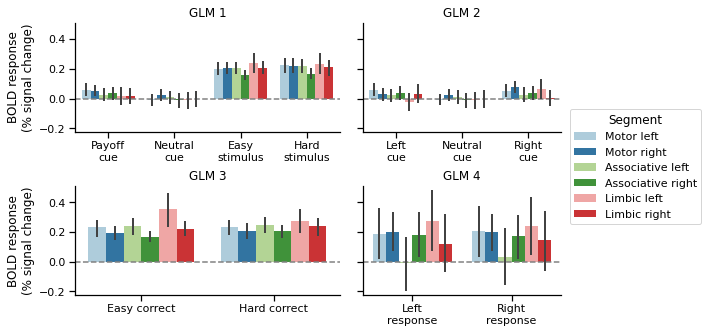

In [47]:
sns.set_context('notebook')
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

ci = 67

f = plt.figure(figsize=(10,5))
gridspec = f.add_gridspec(ncols=2, nrows=2, 
                          wspace=.1, hspace=0.5,
                          width_ratios=[4,3])
# left/right
ax0 = f.add_subplot(gridspec[0,0])
ax1 = f.add_subplot(gridspec[0,1], sharey=ax0)
ax2 = f.add_subplot(gridspec[1,0], sharey=ax0)
ax3 = f.add_subplot(gridspec[1,1], sharey=ax0)
ax = [ax0, ax1, ax2, ax3]

# f, ax = plt.subplots(1,4)#,  sharey='row')
for ax_ in ax:
    ax_.axhline(0, color='grey', linestyle='--')

b1 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM1_betas_long, 
                 ax=ax[0], ci=ci, errwidth=2, #capsize=.05,
                 order=['cue_payoff', 'cue_neutral', 'easy', 'hard'],
                 hue_order=['signal_l_motor', 'signal_r_motor', 'signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic'])
h, l = ax[0].get_legend_handles_labels() #.remove()
b1.legend_.remove()
ax[0].set_xticklabels(['Payoff\ncue', 'Neutral\ncue', 'Easy\nstimulus', 'Hard\nstimulus'])
ax[0].set_title('GLM 1')
ax[0].set_ylabel('BOLD response\n(% signal change)')

b2 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM2_betas_long,
                 ax=ax[1], ci=ci, errwidth=2,
                 order=['cue_left', 'cue_neutral', 'cue_right'],
                 hue_order=['signal_l_motor', 'signal_r_motor', 'signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic'])
b2.legend_.remove()
ax[1].set_xticklabels(['Left\ncue', 'Neutral\ncue', 'Right\ncue'])#, rotation=30, ha='right')
ax[1].set_title('GLM 2')

b3 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['easy_correct', 'hard_correct'])],
                 ax=ax[2], ci=ci, errwidth=2,
                 order=['easy_correct', 'hard_correct'],
                 hue_order=['signal_l_motor', 'signal_r_motor', 'signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic'])
b3.legend_.remove()
ax[2].set_xticklabels(['Easy correct', 'Hard correct'])#, rotation=30, ha='right')
ax[2].set_title('GLM 3')
#ax[2].set_ylabel('BOLD response\n(% signal change)')

b4 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM4_betas_long,
                 ax=ax[3], ci=ci,errwidth=2, 
                 order=['response_left', 'response_right'],
                 hue_order=['signal_l_motor', 'signal_r_motor', 'signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic'])
b4.legend_.remove()
ax[3].set_title('GLM 4')
ax[3].set_xticklabels(['Left\nresponse', 'Right\nresponse'])
#ax[3].yaxis.set_ticklabels([])

ax[3].tick_params(labelleft=False)
ax[1].tick_params(labelleft=False)
#ax[2].yaxis.set_ticklabels([])

for ax_ in ax:
    ax_.set_xlabel('')
for ax_ in [ax[1], ax[3]]:
    ax_.set_ylabel('')
ax[2].set_ylabel('BOLD response\n(% signal change)')

sns.despine()

f.tight_layout()
f.legend(h, ['Motor left', 'Motor right', 'Associative left', 'Associative right', 'Limbic left', 'Limbic right'], loc='center right', title='Segment')
f.subplots_adjust(right=.8)
#f.set_size_inches(15,4)

In [48]:
f.savefig('figures/figure4_size_fixedylabel_accolla.pdf', bbox_inches='tight')

Table 1 in paper

In [49]:
all_stats = pd.concat([results_cue, results_difficulty, results_glm2, results_glm3, results_glm4])
all_stats['bf01'] = 1/all_stats['bf10']

In [50]:
table1_full = all_stats.melt(id_vars=['mask', 'contrast'], value_vars=['t', 'p', 'p.fdr', 'bf01']).pivot_table(values='value', index='mask', columns=['contrast', 'variable']).round(3)

In [51]:
table1_paper = table1_full.iloc[:, table1_full.columns.get_level_values(1).isin(['t', 'bf01'])]
table1_paper = table1_paper.reindex(columns=['t', 'bf01'], level=1)
table1_paper.reindex(['signal_l_motor', 'signal_l_associative', 'signal_l_limbic', 'signal_r_motor', 'signal_r_associative', 'signal_r_limbic']).round(2)

contrast             glm1_cue       glm1_difficulty       glm2_cues        \
variable                    t  bf01               t  bf01         t  bf01   
mask                                                                        
signal_l_motor           2.46  0.40           -0.62  4.51      0.27  5.20   
signal_l_associative     0.47  4.85           -0.44  4.92     -0.00  5.37   
signal_l_limbic          0.89  3.74            0.28  5.18     -1.74  1.40   
signal_r_motor           1.16  2.90           -0.54  4.70     -1.22  2.71   
signal_r_associative     1.86  1.15           -0.42  4.94      0.07  5.36   
signal_r_limbic          0.57  4.61           -0.12  5.34      0.49  4.80   

contrast              glm3        glm4        
variable                 t  bf01     t  bf01  
mask                                          
signal_l_motor        0.03  5.37 -0.77  4.10  
signal_l_associative  0.26  5.20 -1.47  2.03  
signal_l_limbic      -1.06  3.21  0.83  3.90  
signal_r_motor        0.42  4.95  0.24  5.23  
signal_r_associative  1.20  2.78  0.12  5.33  
signal_r_limbic       0.41  4.97 -0.50  4.77

In [52]:
# can we get 95% CI errorbars?

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


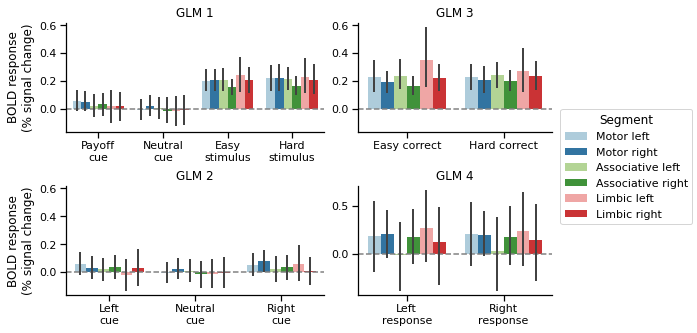

In [53]:
sns.set_context('notebook')
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

ci = 95

f = plt.figure(figsize=(10,5))
gridspec = f.add_gridspec(ncols=2, nrows=2, 
                          wspace=.15, hspace=0.5,
                          width_ratios=[4,3])
# left/right
ax0 = f.add_subplot(gridspec[0,0])
ax1 = f.add_subplot(gridspec[0,1], sharey=ax0)
ax2 = f.add_subplot(gridspec[1,0], sharey=ax0)
ax3 = f.add_subplot(gridspec[1,1])#, sharey=ax2)
ax = [ax0, ax1, ax2, ax3]

# f, ax = plt.subplots(1,4)#,  sharey='row')
for ax_ in ax:
    ax_.axhline(0, color='grey', linestyle='--')

b1 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM1_betas_long, 
                 ax=ax[0], ci=ci, errwidth=2, #capsize=.05,
                 order=['cue_payoff', 'cue_neutral', 'easy', 'hard'],
                 hue_order=['signal_l_motor', 'signal_r_motor', 'signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic'])
h, l = ax[0].get_legend_handles_labels() #.remove()
b1.legend_.remove()
ax[0].set_xticklabels(['Payoff\ncue', 'Neutral\ncue', 'Easy\nstimulus', 'Hard\nstimulus'])
ax[0].set_title('GLM 1')
ax[0].set_ylabel('BOLD response\n(% signal change)')

b2 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM2_betas_long,
                 ax=ax[2], ci=ci, errwidth=2,
                 order=['cue_left', 'cue_neutral', 'cue_right'],
                 hue_order=['signal_l_motor', 'signal_r_motor', 'signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic'])
b2.legend_.remove()
ax[2].set_xticklabels(['Left\ncue', 'Neutral\ncue', 'Right\ncue'])#, rotation=30, ha='right')
ax[2].set_title('GLM 2')

b3 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM3_betas_long.loc[GLM3_betas_long['event type'].isin(['easy_correct', 'hard_correct'])],
                 ax=ax[1], ci=ci, errwidth=2,
                 order=['easy_correct', 'hard_correct'],
                 hue_order=['signal_l_motor', 'signal_r_motor', 'signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic'])
b3.legend_.remove()
ax[1].set_xticklabels(['Easy correct', 'Hard correct'])#, rotation=30, ha='right')
ax[1].set_title('GLM 3')
#ax[2].set_ylabel('BOLD response\n(% signal change)')

b4 = sns.barplot(x='event type', y='beta', hue='roi',
                 palette=sns.color_palette("Paired"),
                 data=GLM4_betas_long,
                 ax=ax[3], ci=ci,errwidth=2, 
                 order=['response_left', 'response_right'],
                 hue_order=['signal_l_motor', 'signal_r_motor', 'signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic'])
b4.legend_.remove()
ax[3].set_title('GLM 4')
ax[3].set_xticklabels(['Left\nresponse', 'Right\nresponse'])
#ax[3].yaxis.set_ticklabels([])

#ax[3].tick_params(labelleft=False)
#ax[1].tick_params(labelleft=False)
#ax[2].yaxis.set_ticklabels([])

for ax_ in ax:
    ax_.set_xlabel('')
for ax_ in [ax[1], ax[3]]:
    ax_.set_ylabel('')
ax[2].set_ylabel('BOLD response\n(% signal change)')

sns.despine()

f.tight_layout()
f.legend(h, ['Motor left', 'Motor right', 'Associative left', 'Associative right', 'Limbic left', 'Limbic right'], loc='center right', title='Segment')
# f.legend(h, ['Associative left', 'Associative right', 'Limbic left', 'Limbic right', 'Motor left', 'Motor right'], loc='center right', title='Segment')
f.subplots_adjust(right=.8)
#f.set_size_inches(15,4)

In [54]:
f.savefig('figures/figure4_95ci_accolla.pdf', bbox_inches='tight')

In [55]:
# this messes up the height of the y-axis...

In [56]:
# sns.set_context('notebook')
# font = {'size'   : 14}
# import matplotlib
# matplotlib.rc('font', **font)

# f = plt.figure(figsize=(9,5))
# gridspec = f.add_gridspec(ncols=2, nrows=2, 
#                           wspace=.1, hspace=0.5,
#                           width_ratios=[4,3])
# # left/right
# ax0 = f.add_subplot(gridspec[0,0])
# ax1 = f.add_subplot(gridspec[0,1], sharey=ax0)
# ax2 = f.add_subplot(gridspec[1,0])
# ax3 = f.add_subplot(gridspec[1,1], sharey=ax2)
# ax = [ax0, ax1, ax2, ax3]

# # f, ax = plt.subplots(1,4)#,  sharey='row')
# for ax_ in ax:
#     ax_.axhline(0, color='grey', linestyle='--')

# b1 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM1_betas_long, 
#                  ax=ax[0], ci=67, errwidth=2, #capsize=.05,
#                  order=['cue_payoff', 'cue_neutral', 'easy', 'hard'],
#                  hue_order=['signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic', 'signal_l_motor', 'signal_r_motor'])
# h, l = ax[0].get_legend_handles_labels() #.remove()
# b1.legend_.remove()
# ax[0].set_xticklabels(['Payoff\ncue', 'Neutral\ncue', 'Easy\nstimulus', 'Hard\nstimulus'])
# ax[0].set_title('GLM 1')
# ax[0].set_ylabel('Beta')

# b2 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM2_betas_long,
#                  ax=ax[1], ci=67, errwidth=2,
#                  order=['cue_left', 'cue_neutral', 'cue_right'],
#                  hue_order=['signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic', 'signal_l_motor', 'signal_r_motor'])
# b2.legend_.remove()
# ax[1].set_xticklabels(['Left\ncue', 'Neutral\ncue', 'Right\ncue'])#, rotation=30, ha='right')
# ax[1].set_title('GLM 2')

# b3 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM3_betas_long,
#                  ax=ax[2], ci=67, errwidth=2,
#                  order=['easy_correct', 'easy_error', 'hard_correct', 'hard_error'],
#                  hue_order=['signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic', 'signal_l_motor', 'signal_r_motor'])
# b3.legend_.remove()
# ax[2].set_xticklabels(['Easy\ncorrect', 'Easy\nerror', 'Hard\ncorrect', 'Hard\nerror'])#, rotation=30, ha='right')
# ax[2].set_title('GLM 3')
# ax[2].set_ylabel('Beta')

# b4 = sns.barplot(x='event type', y='beta', hue='roi',
#                  palette=sns.color_palette("Paired"),
#                  data=GLM4_betas_long,
#                  ax=ax[3], ci=67,errwidth=2, 
#                  order=['response_left', 'response_right'],
#                  hue_order=['signal_l_associative', 'signal_r_associative', 'signal_l_limbic', 'signal_r_limbic', 'signal_l_motor', 'signal_r_motor'])
# b4.legend_.remove()
# ax[3].set_title('GLM 4')
# ax[3].set_xticklabels(['Left\nresponse', 'Right\nresponse'])
# #ax[3].yaxis.set_ticklabels([])

# ax[3].tick_params(labelleft=False)
# ax[1].tick_params(labelleft=False)
# #ax[2].yaxis.set_ticklabels([])


# for ax_ in ax:
#     ax_.set_xlabel('')
# for ax_ in [ax[1], ax[3]]:
#     ax_.set_ylabel('')
# ax[2].set_ylabel('Beta')

# sns.despine()

# f.tight_layout()
# f.legend(h, ['A left', 'A right', 'B left', 'B right', 'C left', 'C right'], loc='center right', title='Subregion')
# f.subplots_adjust(right=.85)
# #f.set_size_inches(15,4)
